# Building an image classifier in TF2.0 (Practical introduction)

## 1. Downloading and preprocessing data

### Settings

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np

In [1]:
!pip install tfds-nightly

     |################################| 3.0MB 930kB/s eta 0:00:01
     |################################| 61kB 6.8MB/s eta 0:00:011
     |################################| 829kB 6.4MB/s eta 0:00:01
     |################################| 153kB 6.7MB/s eta 0:00:01
     |################################| 61kB 8.4MB/s eta 0:00:011
     |################################| 163kB 7.0MB/s eta 0:00:01
     |################################| 133kB 6.7MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/14/2c/cd551d81dbe15200be1cf41cd03869a46fe7226e7450af7a6545bfc474c9/idna-2.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Created wheel for promise: filename=promise-2.2.1-cp36-none-any.whl size=21291 sha256=834cb4fc16aa17fb56a9af8ad8ab76931008100e4bcfbf00f590384f2f54630e
  Stored in directory: /home/kerry/.cache/pip/wheels/92/84/9f/75e2235effae0e

Importing the required libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__

'2.0.0-rc0'

Check out the details (features, statistics, etc.) of the dataset to be downloaded here: https://www.tensorflow.org/datasets/datasets

In [3]:
# List the available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_naturalist2017',
 'image_label_folder',
 'imagenet2012',
 'imagenet

### Download the dataset using `tfds.load()`

In [4]:
# Since "tf_flowers" doesn't define standard splits, 
# use the subsplit feature to divide it into (train, validation, test)
# with 80%, 10%, 10% of the data respectively.
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),
# specifying batch_size=-1 will load full dataset in the memory
#                                                             batch_size=-1,
# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`
# will have a 2-tuple structure `(input, label)`                                                            
                                                            as_supervised=True)

W1204 13:26:41.764137 140154512308032 deprecation.py:323] From /home/kerry/.virtualenvs/tf2.0/lib/python3.6/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to /home/kerry/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Set the training input image dimensions

In [6]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

Create a function which will format the examples in the training dataset as per out needs. The arguments of the `format_example()` depends on the the parameters passed to `tfds.load()`. If `as_supervised=True` then (image, labels) tuple pair will be downloaded else a single dictionary with keys 'image' and 'label' will be passed.

In [7]:
def format_example(image, label):
    print("Format example called!")
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Format example called!
Format example called!
Format example called!


### Peforming Data augmentation
Read more [here](https://stackoverflow.com/questions/55141076/how-to-apply-data-augmentation-in-tensorflow-2-0-after-tfds-load) to know how the map function applies data augmentation

In [8]:
def augment_data(image, label):
  print("Augment data called!")
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  # Add more augmentation of your choice
  return image, label

train = train.map(augment_data)

Augment data called!


Here we'll shuffle the dataset so that we don't have any ordering bias of examples, and create batches of size 32. Setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled. `.prefetch()` lets the dataset fetch batches, in the background while the model is training.

Without prefetch, the CPU and the GPU/TPU sit idle much of the time

![alt text](https://www.tensorflow.org/images/datasets_without_pipelining.png)

With prefetch, idle time diminishes significantly

![alt text](https://www.tensorflow.org/images/datasets_with_pipelining.png)

In [9]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
# (Optional) prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
train = train.prefetch(tf.data.experimental.AUTOTUNE)
print(train)
print(validation)
print(test)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


In [10]:
print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



<b> 
1. TFDS Reference: https://www.tensorflow.org/datasets/overview
2. For importing data from custom URL or disk location refer, Loading images using tf.data: https://www.tensorflow.org/alpha/tutorials/load_data/images

### Visualizing data

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# Get the function which converts label indices to string
get_label_name = metadata.features['label'].int2str

Here we fetch the datatset batch by batch and convert it to numpy array just before passing it to plotting function.

(128, 128, 3)
0.03524497
0.9220003


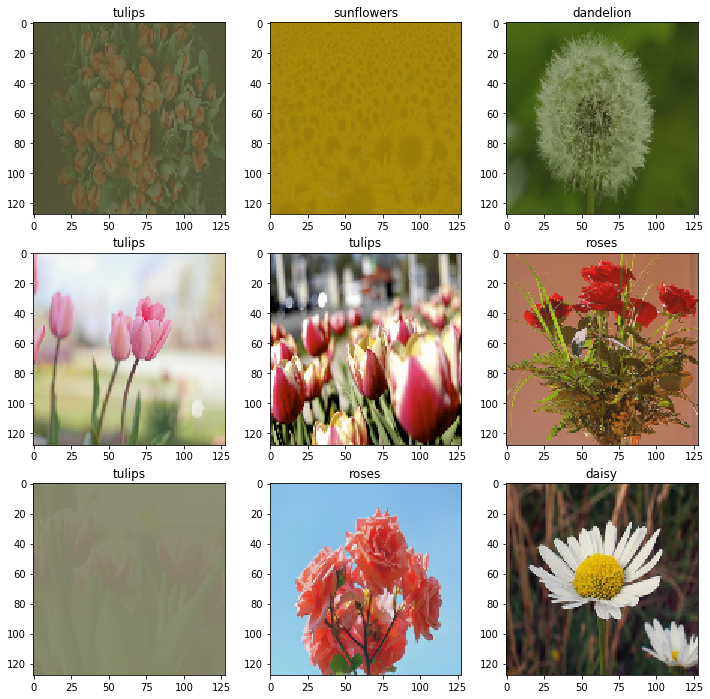

In [16]:
plt.figure(figsize=(12,12)) 
for batch in train.take(1):
    for i in range(9):
        image, label = batch[0][i], batch[1][i]
        plt.subplot(3,3,i+1)
        plt.imshow(image.numpy())
        plt.title(get_label_name(label.numpy()))
        plt.grid(False)
print(image.shape)
print(np.min(image))
print(np.max(image))

## 2. Building an image classifier model using `tf.keras`

In [21]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape `(image_height, image_width, color_channels)`, ignoring the batch size. If you are new to color channels, grayscale images have one, whereas a colored images have three (R,G,B). In this example, we will configure our CNN to process inputs of shape (128, 128, 3). We do this by passing the argument `shape` to our first layer.

To complete our model, we will feed the last output tensor from the convolutional base (of shape (28, 28, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 5 classes, we get that value from the metadata of our downloaded dataset. Hence, we use a final Dense layer with 5 outputs and a softmax activation.

In [22]:
# Creating a simple CNN model in keras using functional API
def create_model():
    img_inputs = keras.Input(shape=IMG_SHAPE)
    conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_2)
    flatten = keras.layers.Flatten()(conv_3)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)
    
    return model

The above model was created using Keras's [Functional API](https://www.tensorflow.org/alpha/guide/keras/functional#training_evaluation_and_inference). However, another way to create models in Keras is to use Keras's Model Subclassing API. This API follows an object oriented structure to build the build models and define it's forward pass. Check out the twitter micro course by the author of keras himself: https://twitter.com/fchollet/status/1105139360226140160

### Visualizing the model

`.summary()` gives us the complete model architecture

In [23]:
simple_model = create_model()
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0     

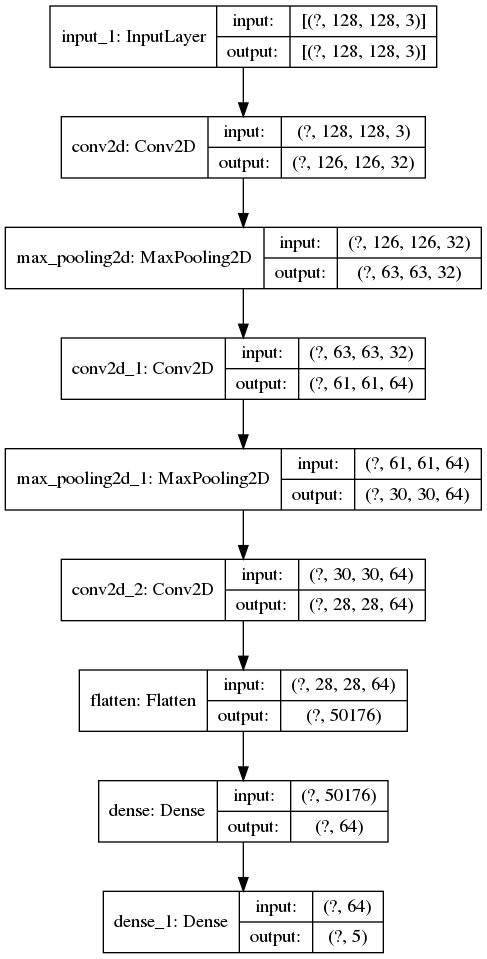

In [24]:
keras.utils.plot_model(simple_model, 'flower_model_with_shape_info.png', show_shapes=True)

### Setting training parameters

We specifiy the directory where tensorboard can save its logs

In [25]:
import datetime, os

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

We also get values of the number of examples in train, val and test sets.
* `steps_per_epoch`: It is the number of batches to train the model in one epoch. Its calculated by dividing the number of training examples by the size of each batch.
* `validation_steps`: It is the same as `steps_per_epoch` but applies to validation dataset

In [26]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples * weight/10 for weight in SPLIT_WEIGHTS
)

steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_val)//BATCH_SIZE

print('Number of examples in the train set:', num_train)
print('Number of examples in the validation set:', num_val)
print('Number of examples in the test set:', num_test)

Number of examples in the train set: 2936.0
Number of examples in the validation set: 367.0
Number of examples in the test set: 367.0


### Compile and train the model

In [27]:
import os

def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Creating Keras callbacks 
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        'training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5)
    os.makedirs('training_checkpoints/', exist_ok=True)
    early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=5)

    history = model.fit(train.repeat(),
              epochs=5, 
              steps_per_epoch=steps_per_epoch,
              validation_data=validation.repeat(),
              validation_steps=validation_steps,
              callbacks=[tensorboard_callback,
                         model_checkpoint_callback,
                         early_stopping_checkpoint])
    
    return history

In [28]:
history = train_model(simple_model)

W1204 13:30:08.434568 140154512308032 callbacks.py:862] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train for 91 steps, validate for 11 steps
Epoch 1/5
91/91 [==============================] - 5s 56ms/step - loss: 1.5186 - accuracy: 0.3438 - val_loss: 1.2512 - val_accuracy: 0.4318
Epoch 2/5
91/91 [==============================] - 3s 34ms/step - loss: 1.3235 - accuracy: 0.4265 - val_loss: 1.2506 - val_accuracy: 0.5028
Epoch 3/5
91/91 [==============================] - 3s 32ms/step - loss: 1.2646 - accuracy: 0.4574 - val_loss: 1.1979 - val_accuracy: 0.5284
Epoch 4/5
91/91 [==============================] - 3s 33ms/step - loss: 1.1966 - accuracy: 0.5114 - val_loss: 1.0675 - val_accuracy: 0.6023
Epoch 5/5
91/91 [==============================] - 3s 32ms/step - loss: 1.1783 - accuracy: 0.5208 - val_loss: 1.0464 - val_accuracy: 0.6080


Plotting the training and validation metrics returned by the `train_model()` routine. We use matplotlib to plot the graph.

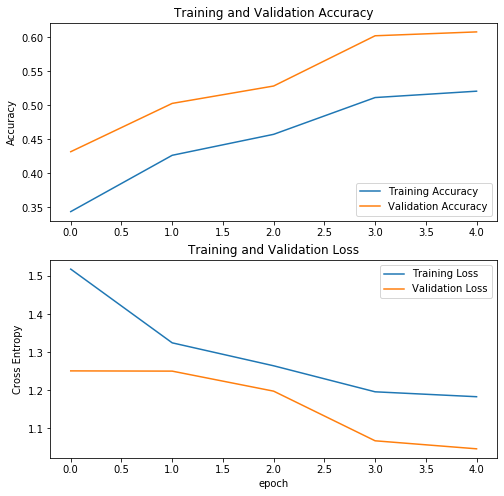

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

These graphs give us insights into how well our model has trained. It is necessary to ensure that both the training and validation accuracies increase and losses decrease.
* If the <b>training accuracy is high but the validation accuracy is low</b>, then it's a typical case of overfitting. You may have to increase your training dataset by performing data augmentation or downloading more images from the internet. You can also try out other model architectures which include regularisation techniques like Dropout and BatchNormalisation.
* If on the other hand your <b>training accuracy and validation accuracy both are higher</b> but, your <b>validation accuracy is slightly higher</b> then maybe your validation dataset comprises of ideal images of the given classes. Sometimes using techniques like dropout and BatchNorm add randomness in training, making training more difficult. To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## 3. Using pre-trained model

The concept of using pre-trained model is to use models developed by AI giants like Google, Amazon and Micorsoft. These models are pre-trained on the ImageNet dataset which is a large dataset of 1.4M images and 1000 classes of web images. These models have already learned the basic features that are common in 1000 objects that we see daily. Hence, these models have a strong feature extraction capabilty.

In [32]:
from tensorflow import keras

# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.InceptionV3(input_shape=IMG_SHAPE,
# We cannot use the top classification layer of the pre-trained model as it contains 1000 classes.
# It also restricts our input dimensions to that which this model is trained on (default: 299x299)
                                               include_top=False, 
                                               weights='imagenet')

87916544/87910968 [==============================] - 27s 0us/step


In [33]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [34]:
keras.utils.plot_model(base_model, 'inception_model_with_shape_info.png', show_shapes=True)

This feature extractor converts each `128x128x3` image to a `2x2x2048` block of features. We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

NOTE: It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting `layer.trainable = False`), we prevent the weights in these layers from being updated during training.

### Adding classification head

To generate predictions from the block of features, average over the spatial 2x2 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2d` layer to convert the features to a single 2048-element vector per image. On top, apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. 

We stack the feature extractor, and these two layers using a tf.keras.Sequential API. Donot forget to compile the model before training.

In [35]:
def build_model():
    
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(metadata.features['label'].num_classes, 
                           activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inception_model = build_model()
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Train the InceptionV3 model

In [36]:
# Evaluating model before training (Optional)
loss0, accuracy0 = inception_model.evaluate(validation.repeat(), steps = validation_steps)

11/11 [==============================] - 2s 159ms/step - loss: 3.4909 - accuracy: 0.1420


In [37]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

# Creating Keras callbacks 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5)
os.makedirs('training_checkpoints/', exist_ok=True)
early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=5)



history = inception_model.fit(train.repeat(),
                              epochs=5,
                              steps_per_epoch = steps_per_epoch,
                              validation_data=validation.repeat(), 
                              validation_steps=validation_steps,
                              callbacks=[tensorboard_callback,
                              model_checkpoint_callback,
                              early_stopping_checkpoint])

W1204 13:31:47.779028 140154512308032 callbacks.py:862] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train for 91 steps, validate for 11 steps
Epoch 1/5
91/91 [==============================] - 8s 83ms/step - loss: 1.4237 - accuracy: 0.4052 - val_loss: 1.9478 - val_accuracy: 0.5199
Epoch 2/5
91/91 [==============================] - 5s 55ms/step - loss: 1.0871 - accuracy: 0.5877 - val_loss: 2.4221 - val_accuracy: 0.5455
Epoch 3/5
91/91 [==============================] - 5s 51ms/step - loss: 1.0323 - accuracy: 0.6109 - val_loss: 1.9797 - val_accuracy: 0.6108
Epoch 4/5
91/91 [==============================] - 5s 50ms/step - loss: 0.9553 - accuracy: 0.6421 - val_loss: 2.0508 - val_accuracy: 0.5767
Epoch 5/5
91/91 [==============================] - 5s 55ms/step - loss: 0.9160 - accuracy: 0.6441 - val_loss: 2.6780 - val_accuracy: 0.5341


After training the model for 5 epochs we were able to get ~70% accuracy. We plot the learning curves of the training and validation accuracy / loss.

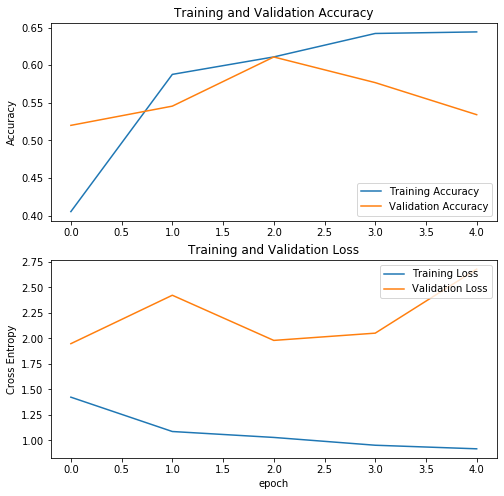

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
# Save keras model
inception_model.save('inception_v3_128_tf_flowes.h5')

In [40]:
loaded_model = keras.models.load_model('inception_v3_128_tf_flowes.h5')
loaded_model.evaluate(test)

W1204 13:32:27.472543 140154512308032 deprecation.py:323] From /home/kerry/.virtualenvs/tf2.0/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


12/12 [==============================] - 2s 154ms/step - loss: 2.7380 - accuracy: 0.5278


[2.7379798690478006, 0.5277778]

### Fine tuning the model

In our feature extraction experiment, we were only training a few layers on top of an Inception V3 base model. The weights of the pre-trained network were <b>not</b> updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the model was trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

In [41]:
# Un-freeze the top layers of the model
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [42]:
# Fine tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
inception_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 11,125,125
Non-trainable params: 10,687,904
_________________________________________________________________


If you trained to convergence earlier, this will get you a few percent more accuracy.

In [43]:
history_fine = inception_model.fit(train.repeat(), 
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=10, 
                                  initial_epoch = 5,
                                  validation_data=validation.repeat(), 
                                  validation_steps=validation_steps,
                                  callbacks=[tensorboard_callback,
                                  model_checkpoint_callback,
                                  early_stopping_checkpoint])

Train for 91 steps, validate for 11 steps
Epoch 6/10
91/91 [==============================] - 11s 117ms/step - loss: 0.8181 - accuracy: 0.6964 - val_loss: 1.9216 - val_accuracy: 0.6790
Epoch 7/10
91/91 [==============================] - 5s 59ms/step - loss: 0.6053 - accuracy: 0.7789 - val_loss: 2.1121 - val_accuracy: 0.7045
Epoch 8/10
91/91 [==============================] - 5s 59ms/step - loss: 0.5250 - accuracy: 0.8101 - val_loss: 1.5900 - val_accuracy: 0.7472
Epoch 9/10
91/91 [==============================] - 5s 58ms/step - loss: 0.4640 - accuracy: 0.8292 - val_loss: 2.0124 - val_accuracy: 0.7045
Epoch 10/10
91/91 [==============================] - 6s 62ms/step - loss: 0.4152 - accuracy: 0.8507 - val_loss: 2.1379 - val_accuracy: 0.7244


Note: If the training dataset is fairly small, and is similar to the original datasets that Inception V3 was trained on, so fine-tuning may result in overfitting.

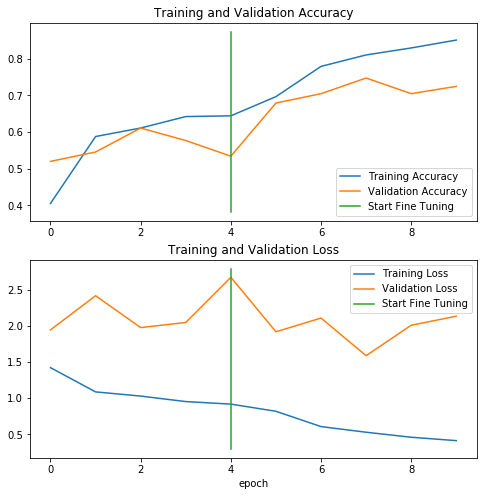

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

initial_epochs=5

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In summary here is what we covered on how to do transfer learning using a pre-trained model to improve accuracy: 
* Using a pre-trained model for <b>feature extraction</b> - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training. In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs. 
* <b>Fine-tuning</b> a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.

References: 
1. https://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns
2. https://www.tensorflow.org/alpha/tutorials/images/transfer_learning